# SUDOKU DETECTION

## PREPARING THE ENVIRONMENT

Importing the libraries:

In [1]:
import sys

sys.path.append('../')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model

from sudoku import solver_backtracking_for_csp

Declaring constants and defining auxiliary functions:

In [3]:
SHAPE      = 450, 450
SHAPE_CELL =  32,  32
MIN_AREA   = (SHAPE[0] * SHAPE[1]) / 4


def preprocess(image):
    image_resized    = cv2.resize(image, SHAPE)
    image_gaussian   = cv2.GaussianBlur(image_resized, (3, 3), 6)
    image_threshold  = cv2.adaptiveThreshold(image_gaussian, 255, 1, 1, 11, 2)
    image_median     = cv2.medianBlur(image_threshold, 3)

    return image_median

def biggest_contour(contours):
    contour  = None
    max_area = 0

    for c in contours:
        area = cv2.contourArea(c)

        if area < MIN_AREA:
            continue

        perimeter    = cv2.arcLength(c, True)
        approx_curve = cv2.approxPolyDP(c, 0.02* perimeter, True)

        if area > max_area and len(approx_curve) == 4:
            contour  = approx_curve
            max_area = area

    return contour

def reframe(points):
    points = points.reshape((4, 2))
    reordered_points = np.zeros((4, 1, 2), dtype=np.float32)

    point_sums = points.sum(axis=1)
    point_diff = np.diff(points, axis=1)

    reordered_points[0] = points[np.argmin(point_sums)]
    reordered_points[3] = points[np.argmax(point_sums)]
    reordered_points[1] = points[np.argmin(point_diff)]
    reordered_points[2] = points[np.argmax(point_diff)]

    return reordered_points

def get_perspective(image, shape, contour):
    p1 = reframe(contour)
    p2 = np.float32([[  0,   0],
                     [450,   0],
                     [  0, 450],
                     [450, 450]])
    m = cv2.getPerspectiveTransform(p1, p2)

    return cv2.warpPerspective(image, m, shape)

def get_number(cell):
    contours, _ = cv2.findContours(cell,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return cell

    contour = max(contours, key=len)
    if len(contour) < 10:
        return cell

    x, y, w, h = cv2.boundingRect(contour)

    side_length = max(w, h)
    x_center = x + w // 2
    y_center = y + h // 2
    x_square = x_center - side_length // 2
    y_square = y_center - side_length // 2

    x_square = max(x_square, 0)
    y_square = max(y_square, 0)
    x_square_end = min(x_square + side_length, cell.shape[1])
    y_square_end = min(y_square + side_length, cell.shape[0])

    return cell[y_square : y_square_end,
                x_square : x_square_end]

def split_cells(image):
    return [cell
            for row  in np.vsplit(image, 9)
            for cell in np.hsplit(row  , 9)]

## PRE-PROCESSING

Loading image for testing and digit recognition model:

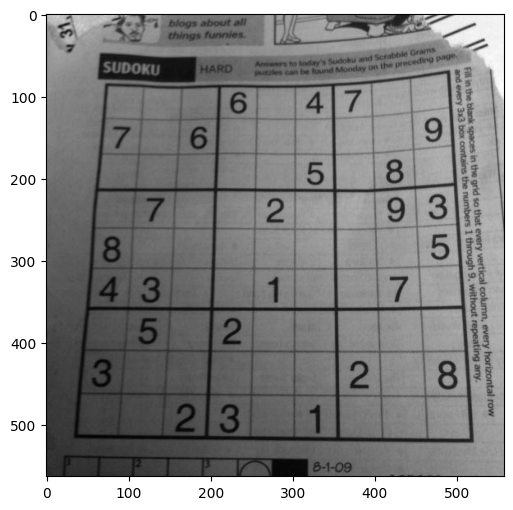

In [4]:
file_path  = '..\\examples\\sudoku_test.png'
model_path = '..\\models\\digits.keras'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
model = load_model(model_path)

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.show()

Pre-processing the image:

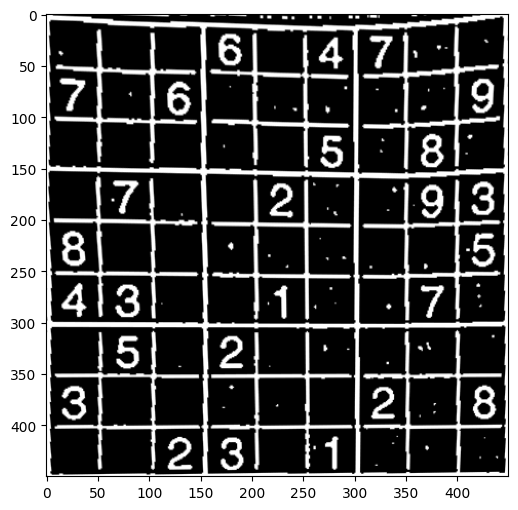

In [5]:
image_processed = preprocess(image)

contours, _ = cv2.findContours(image_processed,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contour = biggest_contour(contours)

image_sudoku = get_perspective(image_processed, SHAPE, contour)

plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()

Getting the grid digits:

In [6]:
cells = split_cells(image_sudoku)

grid = np.zeros(81, 'uint8')
for idx, cell in enumerate(cells):
    if np.sum(cell) < 135000:
        continue

    cell = get_number(cell[5:-5, 5:-5])
    cell = cv2.resize(cell, SHAPE_CELL)
    cell = cell / 255.

    cell = np.expand_dims(cell, axis=[0, -1])
    pred = model.predict(cell, verbose=0).squeeze()

    label = np.argmax(pred)
    if pred[label] >= 0.5:
        grid[idx] = label

grid = grid.reshape(9, 9)
grid

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [4, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 2, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]], dtype=uint8)

Solving by searching for constraint satisfaction:

In [7]:
solver_backtracking_for_csp(grid)

array([[5, 8, 3, 6, 9, 4, 7, 2, 1],
       [7, 1, 6, 8, 3, 2, 5, 4, 9],
       [2, 9, 4, 1, 7, 5, 3, 8, 6],
       [6, 7, 1, 5, 2, 8, 4, 9, 3],
       [8, 2, 9, 7, 4, 3, 1, 6, 5],
       [4, 3, 5, 9, 1, 6, 8, 7, 2],
       [1, 5, 8, 2, 6, 7, 9, 3, 4],
       [3, 6, 7, 4, 5, 9, 2, 1, 8],
       [9, 4, 2, 3, 8, 1, 6, 5, 7]], dtype=uint8)

## TESTING ANOTHER IMAGE

Loading the test image:

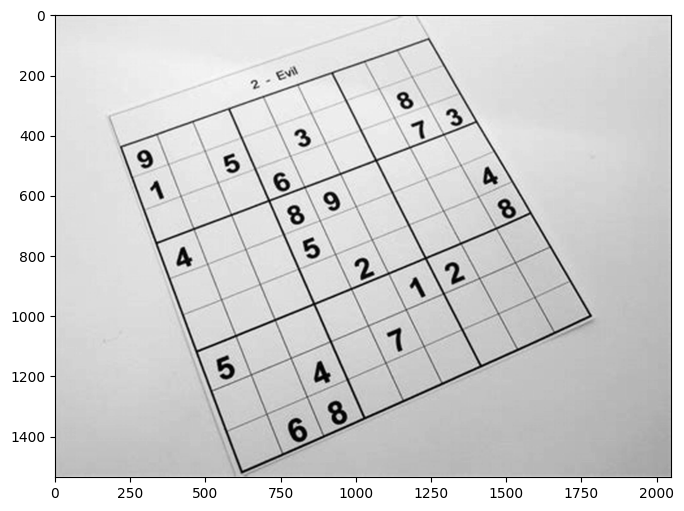

In [8]:
file_path  = '..\\examples\\sudoku_test_00.jpg'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.show()

Pre-processing the image:

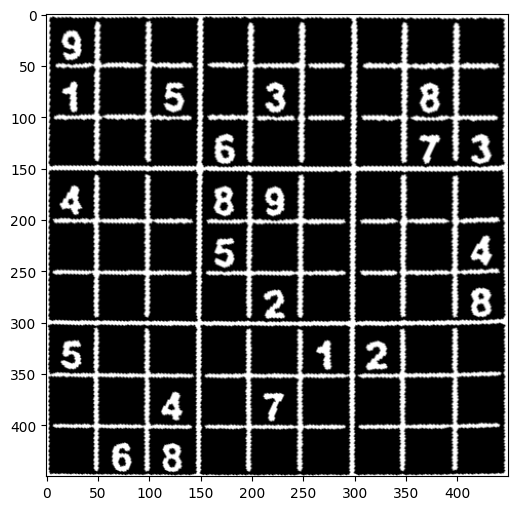

In [9]:
image_processed = preprocess(image)

contours, _ = cv2.findContours(image_processed,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contour = biggest_contour(contours)

image_sudoku = get_perspective(image_processed, SHAPE, contour)

plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()

Getting the digits present in the game:

In [10]:
cells = split_cells(image_sudoku)

grid = np.zeros(81, 'uint8')
for idx, cell in enumerate(cells):
    if np.sum(cell) < 135000:
        continue

    cell = get_number(cell[5:-5, 5:-5])
    cell = cv2.resize(cell, SHAPE_CELL)
    cell = cell / 255.

    cell = np.expand_dims(cell, axis=[0, -1])
    pred = model.predict(cell, verbose=0).squeeze()

    label = np.argmax(pred)
    if pred[label] >= 0.5:
        grid[idx] = label

grid = grid.reshape(9, 9)
grid

array([[9, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 5, 0, 3, 0, 0, 8, 0],
       [0, 0, 0, 6, 0, 0, 0, 7, 3],
       [4, 0, 0, 8, 9, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 2, 0, 0, 0, 8],
       [5, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 4, 0, 7, 0, 0, 0, 0],
       [0, 6, 8, 0, 0, 0, 0, 0, 0]], dtype=uint8)

Solving by searching for constraint satisfaction:

In [11]:
solver_backtracking_for_csp(grid)

array([[9, 3, 6, 7, 1, 8, 4, 5, 2],
       [1, 7, 5, 4, 3, 2, 6, 8, 9],
       [8, 4, 2, 6, 5, 9, 1, 7, 3],
       [4, 2, 3, 8, 9, 7, 5, 6, 1],
       [7, 8, 1, 5, 6, 3, 9, 2, 4],
       [6, 5, 9, 1, 2, 4, 7, 3, 8],
       [5, 9, 7, 3, 8, 1, 2, 4, 6],
       [3, 1, 4, 2, 7, 6, 8, 9, 5],
       [2, 6, 8, 9, 4, 5, 3, 1, 7]], dtype=uint8)